# Signal and noise histograms (from simtel files)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

import sys
sys.path.append("..")
import datapipe
import datapipe.io.montecarlo_calibration_astri as mc_calibration

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

#ctapipe.version.get_version()
print(ctapipe.__version__)
print(pyhessio.__version__)

from ctapipe.instrument import CameraGeometry

In [4]:
MAX_NUM_SAMPLES = 2000000

## Common functions

In [5]:
def plot_all(simtel_file,
             tel_id_filter_list,
             channel_threshold,
             cam_id,
             max_num_samples=1000000):

    print("Cam ID:", cam_id)
    print("Simtel file:", simtel_file)
    print("Tel ID range:", tel_id_filter_list)

    source = hessio_event_source(simtel_file, allowed_tels=tel_id_filter_list)

    #in_sample_list = []
    sig_sample_list = []
    #noise_sample_list = []
    noise2_sample_list = []
    
    # ITERATE OVER EVENTS #############################################

    for ev in source:

        if len(sig_sample_list) >= max_num_samples:
            break
        
        #calib.calibrate(ev)  # calibrate the event
        
        # ITERATE OVER IMAGES #########################################

        for tel_id in ev.trig.tels_with_trigger:
            
            if len(sig_sample_list) >= max_num_samples:
                break

            tel_id = int(tel_id)

            if tel_id in tel_id_filter_list:

                # CHECK THE IMAGE GEOMETRY ############################

                x, y = ev.inst.pixel_pos[tel_id]
                foclen = ev.inst.optical_foclen[tel_id]
                geom = ctapipe.instrument.CameraGeometry.guess(x, y, foclen)

                if geom.cam_id != cam_id:
                    raise ValueError("Telescope {}: error (the input image is not a valide {} telescope image but a {} telescope image)".format(tel_id, cam_id, geom.cam_id))

                # GET IMAGES ##########################################

                pe_image = ev.mc.tel[tel_id].photo_electron_image  # 1D np array
                uncalibrated_image = ev.r0.tel[tel_id].adc_sums   # ctapipe 0.4.0
                pedestal = ev.mc.tel[tel_id].pedestal
                gain = ev.mc.tel[tel_id].dc_to_pe
                #pixel_pos = ev.inst.pixel_pos[tel_id]
                #calibrated_image = ev.dl1.tel[tel_id].image
                
                calibrated_image = mc_calibration.apply_mc_calibration(uncalibrated_image, pedestal, gain)
                
                # ADD SAMPLES #########################################

                #in_sample_list.append(calibrated_image)
                sig_sample_list.append(pe_image)
                #noise_sample_list.append(calibrated_image - pe_image)
                noise2_sample_list.extend(calibrated_image[pe_image == 0.].tolist())

    #in_sample_array = np.array(in_sample_list).ravel()
    
    sig_sample_array = np.array(sig_sample_list).ravel()
    del sig_sample_list
    
    #noise_sample_array = np.array(noise_sample_list).ravel()
    
    noise2_sample_array = np.array(noise2_sample_list)
    del noise2_sample_list

    # PLOT ############################################################
    
    fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(13, 13))
    
    num_bins = 100
    
    print("Num samples:", len(sig_sample_array))
    print("Memory usage for sig_sample_array: {} Mb".format(sig_sample_array.nbytes / 1000000.))
    print("Memory usage for noise2_sample_array: {} Mb".format(noise2_sample_array.nbytes / 1000000.))
    
    #plt.hist(in_sample_array, bins=num_bins, range=(-10, 2500), log=True);

    ax1.hist(sig_sample_array,
             bins=num_bins,
             range=(-10, 2500),
             log=True)

    #plt.hist(noise_sample_array,
    #         bins=num_bins,
    #         range=(-50, 50),
    #         log=False);

    ax2.hist(noise2_sample_array,
             bins=num_bins,
             #range=(-10, 50),
             log=False)
    
    print("Noise: Mean = {} ; Std = {}".format(noise2_sample_array.mean(), noise2_sample_array.std()))

## ASTRI : former calibration method

Cam ID: ASTRICam
Simtel file: /Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz
Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Num samples: 35280832
Memory usage for sig_sample_array: 141.123328 Mb
Memory usage for noise2_sample_array: 273.958416 Mb
Noise: Mean = 2.3908609943024826 ; Std = 1.6126124149838617
CPU times: user 3min 48s, sys: 6.95 s, total: 3min 55s
Wall time: 4min 6s


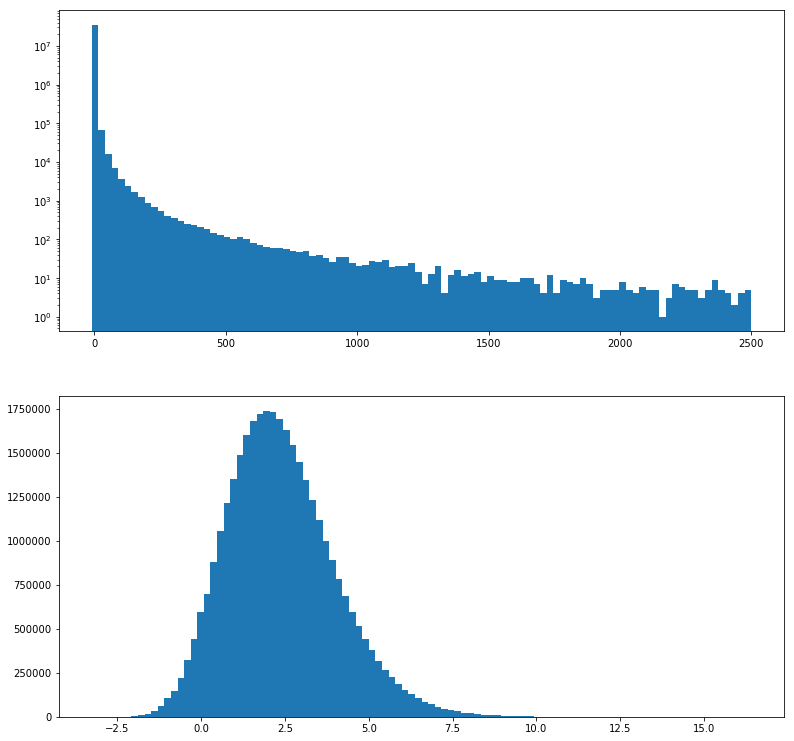

In [6]:
%%time

channel_threshold = 14   # FYI Tino uses 14

gamma_file_path =  "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/gamma/run1001.simtel.gz"
proton_file_path = "/Users/jdecock/vm-shared/data/astri_mini_array/simtel/proton/run10001.simtel.gz"

plot_all(gamma_file_path,
         tel_id_filter_list=list(range(1, 34)),
         channel_threshold=channel_threshold,
         cam_id="ASTRICam",
         max_num_samples=MAX_NUM_SAMPLES)